In [1]:
import codigo
from codigo import utils
from codigo import model_LSTM
from codigo import model_utils
from cg_ega.cg_ega import CG_EGA

In [2]:
import pandas as pd
import numpy as np
pd.set_option('mode.chained_assignment',None)
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow import keras

In [4]:
modeloBasePath='modelos/modeloGeneral/vanilla_dropout.h5'
modeloSave='/transfer_vanilla_dropout.h5'

In [5]:
balanceo='_down_equals'

In [6]:
from pickle import load
scalerGlucosa = load(open('dataset/generado/scalerGlucosa.scaler', 'rb'))

# Paciente Q1

In [7]:
paciente='paciente1'

In [8]:
with open('dataset/generado/'+paciente+'/array_Xtrain'+balanceo+'.npy', 'rb') as f:
    array_Xtrain = np.load(f)

In [9]:
len(array_Xtrain)

237

In [10]:
with open('dataset/generado/'+paciente+'/array_Ytrain'+balanceo+'.npy', 'rb') as f:
    array_Ytrain = np.load(f)

In [11]:
len(array_Ytrain)

237

In [12]:
with open('dataset/generado/'+paciente+'/array_Xval'+balanceo+'.npy', 'rb') as f:
    array_Xval = np.load(f)

In [13]:
len(array_Xval)

51

In [14]:
with open('dataset/generado/'+paciente+'/array_Yval'+balanceo+'.npy', 'rb') as f:
    array_Yval = np.load(f)

In [15]:
len(array_Yval)

51

In [16]:
with open('dataset/generado/'+paciente+'/array_Xtest.npy', 'rb') as f:
    array_Xtest = np.load(f)

In [17]:
len(array_Xtest)

191

In [18]:
with open('dataset/generado/'+paciente+'/array_Ytest.npy', 'rb') as f:
    array_Ytest = np.load(f)

In [19]:
len(array_Ytest)

191

In [20]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mae', mode='min', patience=3, min_delta=0.001)

# Rendimiento del Modelo base

In [21]:
base_model = keras.models.load_model(modeloBasePath)

6/6 [==============================] - 1s 9ms/step


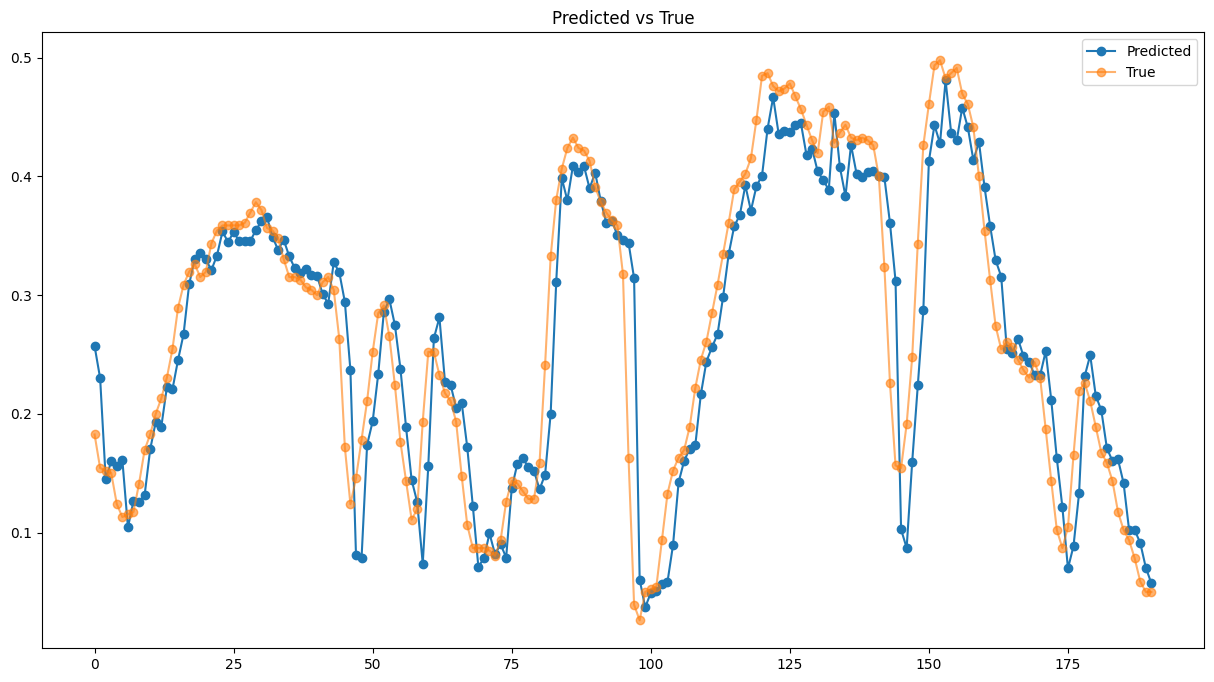

In [22]:
yhat = base_model.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [23]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.03631403151294948,
 'mse': 0.05150329549445391,
 'rmse': 0.0026525894467890367}

# Iniciamos transfer learning

In [24]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 3

In [25]:
base_model.layers[-2].output

<KerasTensor: shape=(None, 32) dtype=float32 (created by layer 'dropout_2')>

In [26]:
transferModel=model_LSTM.transferLearning_NewModel(base_model,-2,True)
transferModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 5)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0     

In [27]:
array_Xtrain.shape

(237, 30, 5)

In [28]:
transferModel.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mae','mse'])

history =transferModel.fit(array_Xtrain, array_Ytrain,epochs=epochs, validation_data=(array_Xval, array_Yval), shuffle=False, callbacks=[early_stopping])
transferModel.save('modelos/'+paciente+modeloSave)

Epoch 1/100
8/8 [==============================] - 4s 106ms/step - loss: 0.0596 - mae: 0.1817 - mse: 0.0596 - val_loss: 0.0531 - val_mae: 0.1807 - val_mse: 0.0531
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0521 - mae: 0.1804 - mse: 0.0521 - val_loss: 0.0509 - val_mae: 0.1777 - val_mse: 0.0509
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0532 - mae: 0.1759 - mse: 0.0532 - val_loss: 0.0488 - val_mae: 0.1747 - val_mse: 0.0488
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0491 - mae: 0.1713 - mse: 0.0491 - val_loss: 0.0468 - val_mae: 0.1717 - val_mse: 0.0468
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0466 - mae: 0.1661 - mse: 0.0466 - val_loss: 0.0448 - val_mae: 0.1687 - val_mse: 0.0448
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0439 - mae: 0.1647 - mse: 0.0439 - val_loss: 0.0429 - val_mae: 0.1656 - val_mse: 0.0429
Epoch 7/100
8/8 [==========

8/8 [==============================] - 0s 29ms/step - loss: 0.0087 - mae: 0.0725 - mse: 0.0087 - val_loss: 0.0070 - val_mae: 0.0647 - val_mse: 0.0070
Epoch 52/100
8/8 [==============================] - 0s 31ms/step - loss: 0.0118 - mae: 0.0777 - mse: 0.0118 - val_loss: 0.0068 - val_mae: 0.0637 - val_mse: 0.0068
Epoch 53/100
8/8 [==============================] - 0s 30ms/step - loss: 0.0091 - mae: 0.0746 - mse: 0.0091 - val_loss: 0.0066 - val_mae: 0.0624 - val_mse: 0.0066
Epoch 54/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0111 - mae: 0.0787 - mse: 0.0111 - val_loss: 0.0065 - val_mae: 0.0615 - val_mse: 0.0065
Epoch 55/100
8/8 [==============================] - 0s 28ms/step - loss: 0.0095 - mae: 0.0758 - mse: 0.0095 - val_loss: 0.0065 - val_mae: 0.0612 - val_mse: 0.0065
Epoch 56/100
8/8 [==============================] - 0s 25ms/step - loss: 0.0091 - mae: 0.0729 - mse: 0.0091 - val_loss: 0.0064 - val_mae: 0.0606 - val_mse: 0.0064
Epoch 57/100
8/8 [=================

6/6 [==============================] - 0s 15ms/step - loss: 0.0062 - mae: 0.0660 - mse: 0.0062
test loss, test acc: [0.0061722700484097, 0.06603255867958069, 0.0061722700484097]


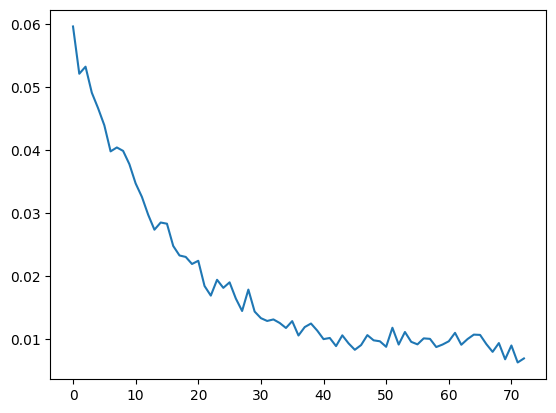

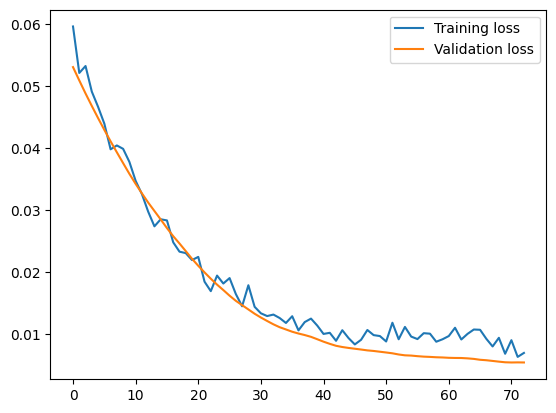

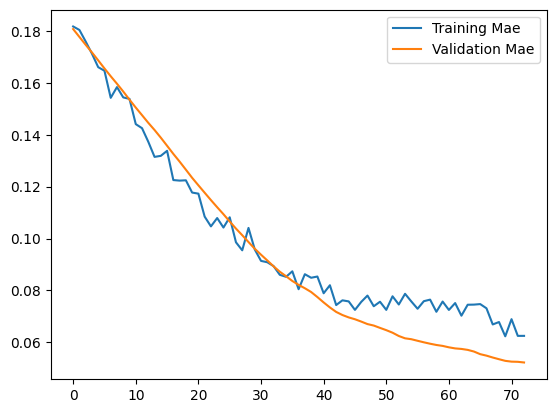

In [29]:
model_utils.modelEvaluateTraining(transferModel,history,array_Xtest, array_Ytest)

6/6 [==============================] - 0s 8ms/step


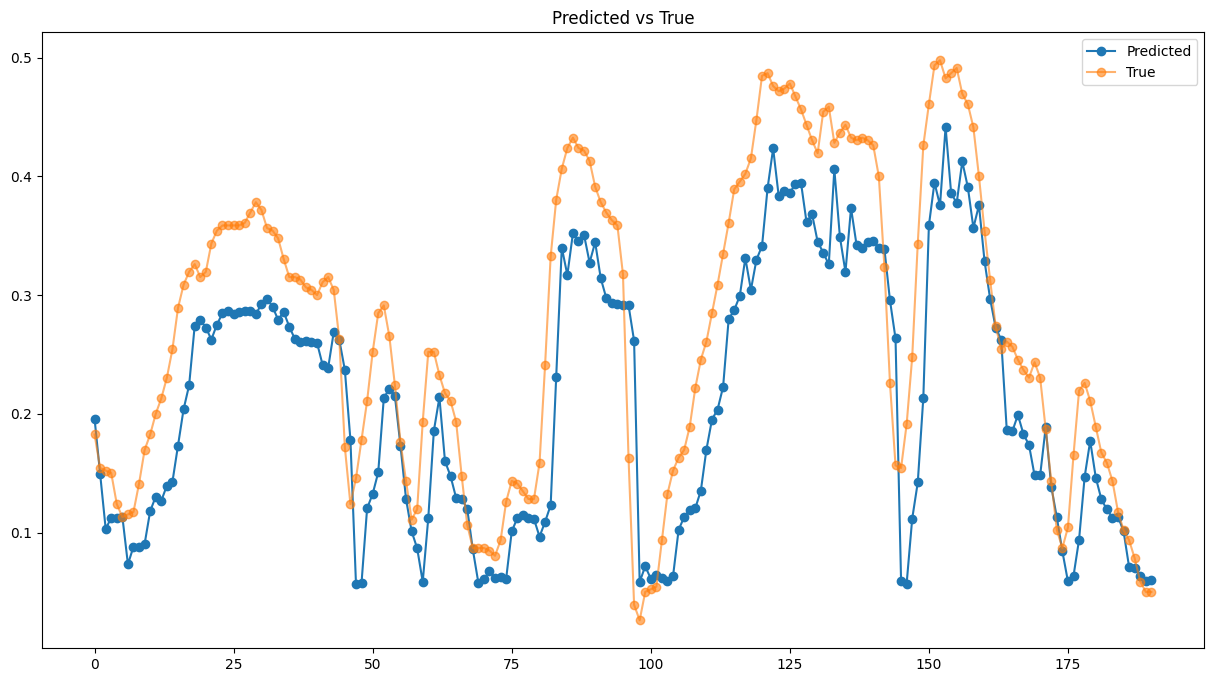

In [30]:
yhat = transferModel.predict(array_Xtest)
model_utils.plotPredicted(yhat,array_Ytest)

In [31]:
model_utils.forecast_accuracy(yhat,array_Ytest)

{'mae': 0.06603255606517824,
 'mse': 0.07856379529900312,
 'rmse': 0.006172269931783664}

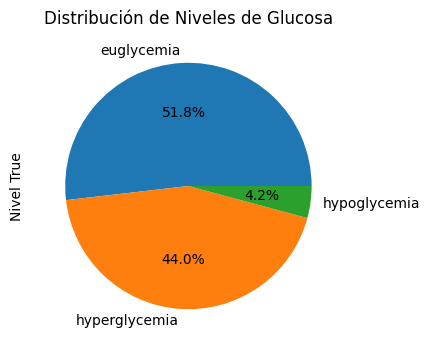

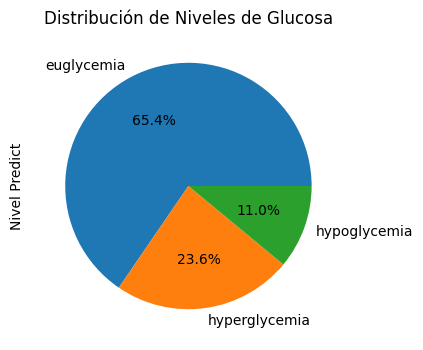

,Glucose level True,Nivel True,Glucose level Predict,Nivel Predict
0,124.0,euglycemia,130.094391,euglycemia
1,111.0,euglycemia,108.773430,euglycemia
2,110.0,euglycemia,87.418015,euglycemia
3,109.0,euglycemia,91.710571,euglycemia
4,97.0,euglycemia,91.523293,euglycemia


In [32]:
Y_scaled=scalerGlucosa.inverse_transform(array_Ytest)
yhat_scaled=scalerGlucosa.inverse_transform(yhat)

df_glucose = pd.DataFrame(Y_scaled, columns=['Glucose level True']) 
df_glucose['Nivel True'] = df_glucose['Glucose level True'].apply(utils.label_LevelBG) 
df_glucose['Nivel True'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose['Glucose level Predict']=yhat_scaled
df_glucose['Nivel Predict'] = df_glucose['Glucose level Predict'].apply(utils.label_LevelBG) 

df_glucose['Nivel Predict'].value_counts().plot.pie(title='Distribución de Niveles de Glucosa',y='level_label',legend=False,autopct='%1.1f%%',figsize=(10, 4))
plt.show()

df_glucose.head()


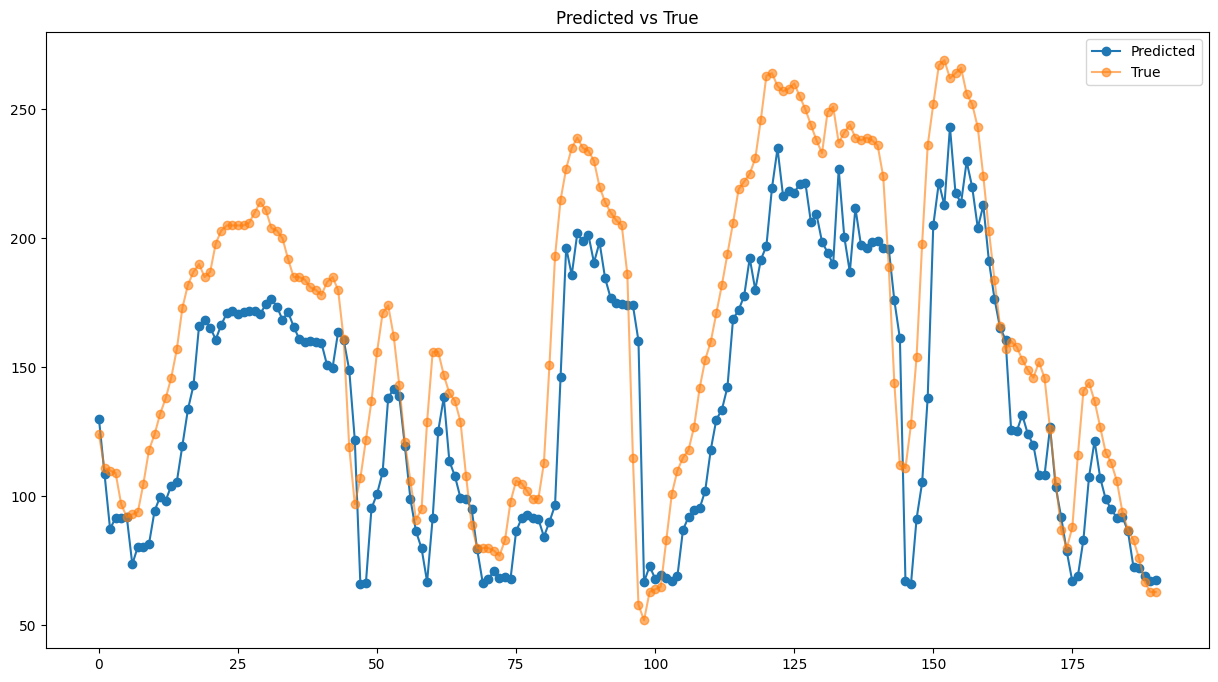

{'mae': 30.374974675203493,
 'mse': 36.1393447571167,
 'rmse': 1306.0522394737384}

In [33]:
model_utils.plotPredicted(yhat_scaled,Y_scaled)
model_utils.forecast_accuracy(yhat_scaled,Y_scaled)

In [34]:
dfPlot=pd.DataFrame()
dfPlot['y_true']=df_glucose['Glucose level True']
dfPlot['y_pred']=df_glucose['Glucose level Predict']
dfPlot.index=pd.date_range("2023-01-01", periods=len(df_glucose['Glucose level True']), freq="15min")
dfPlot

,y_true,y_pred
2023-01-01 00:00:00,124.0,130.094391
2023-01-01 00:15:00,111.0,108.773430
2023-01-01 00:30:00,110.0,87.418015
2023-01-01 00:45:00,109.0,91.710571
2023-01-01 01:00:00,97.0,91.523293
...,...,...
2023-01-02 22:30:00,83.0,72.566917
2023-01-02 22:45:00,76.0,72.440269
2023-01-02 23:00:00,67.0,69.229141
2023-01-02 23:15:00,63.0,67.391907


AP, BE, EP: (0.9105263157894737, 0.07894736842105263, 0.010526315789473684)


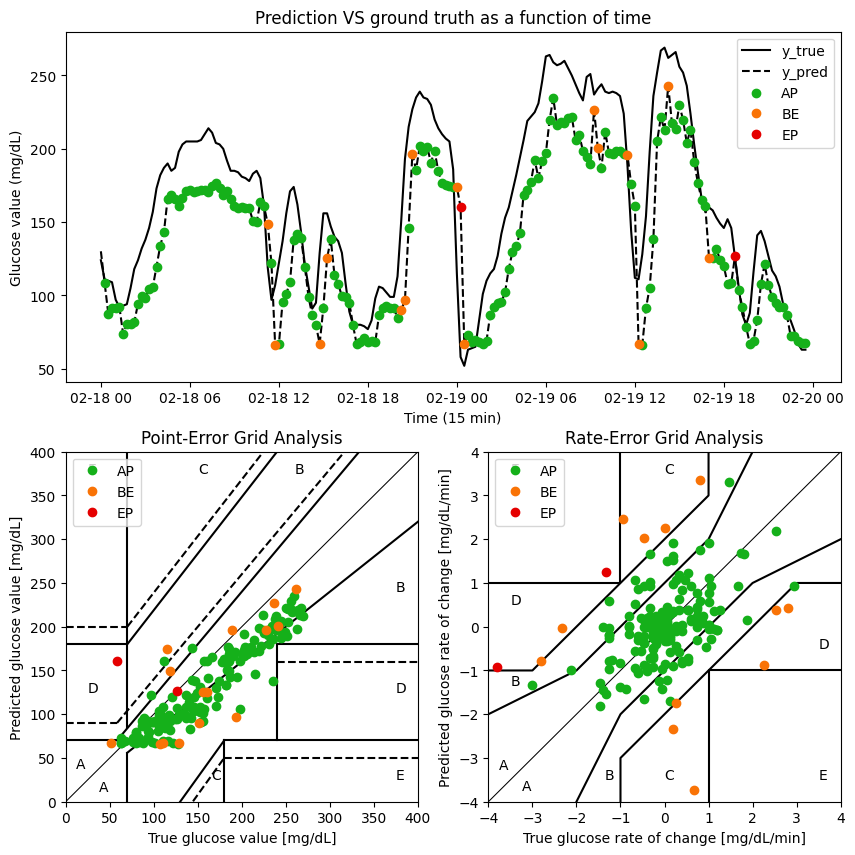

In [35]:
freq = 15
cg_ega = CG_EGA(dfPlot, freq)
print("AP, BE, EP:", cg_ega.reduced())
cg_ega.plot(day=5)